<a href="https://colab.research.google.com/github/anishjohnson/Face-Emotion-Recognition/blob/main/FER/Colab%20Notebook/Face_Emotion_Recognition_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
!nvidia-smi
!nvcc -V

Sat Mar 18 11:44:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.33       Driver Version: 528.33       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8     9W /  80W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [2]:
# Basic python libraries.
import glob
import os.path as osp
import datetime
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools
# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.utils.data as data
import shutil
import time
from tqdm import tqdm
print('Above libraries have been imported.')

Above libraries have been imported.


# **Data Preprocessing:**

In [3]:
def model_configuration():
  # Generic config
    width, height, channels = 48, 48, 3
    batch_size = 128
    num_classes = 7
  # validation_split = 0.1 # 45/5 per the He et al. paper
    verbose = 1
    n = 3
    init_fm_dim = 64
    shortcut_type = "identity" # or: projection

    # Create config dictionary
    config = {
        "width": width,
        "height": height,
        "dim": channels,
        "batch_size": batch_size,
        "num_classes": num_classes,
        "verbose": verbose,
        "stack_n": n,
        "initial_num_feature_maps": init_fm_dim,
        # "training_ds_size": train_size,
        # "steps_per_epoch": steps_per_epoch,
        # "val_steps_per_epoch": val_steps_per_epoch,
        "shortcut_type": shortcut_type
    }
    return config

# **Build Dataset:**

In [4]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [5]:
resize = 48
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)

In [6]:
def make_datapath_list(phase='train'):
    rootpath = './dataset/'
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

In [7]:
path_list = make_datapath_list('train')

./dataset/train/**/*.jpg


In [8]:
path_list[:10]

['./dataset/train\\angry\\Training_10118481.jpg',
 './dataset/train\\angry\\Training_10120469.jpg',
 './dataset/train\\angry\\Training_10131352.jpg',
 './dataset/train\\angry\\Training_10161559.jpg',
 './dataset/train\\angry\\Training_1021836.jpg',
 './dataset/train\\angry\\Training_10269675.jpg',
 './dataset/train\\angry\\Training_10278738.jpg',
 './dataset/train\\angry\\Training_10290703.jpg',
 './dataset/train\\angry\\Training_10295477.jpg',
 './dataset/train\\angry\\Training_10315441.jpg']

In [9]:
train_list = make_datapath_list('train')
val_list = make_datapath_list('val')

./dataset/train/**/*.jpg
./dataset/val/**/*.jpg


In [10]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('\\')[1]
        
        if label == "angry":
            label = 0
        elif label == "disgust":
            label = 1
        elif label == "fear":
            label = 2
        elif label == "happy":
            label = 3
        elif label == "neutral":
            label = 4
        elif label == "sad":
            label = 5
        elif label == "surprise":
            label = 6
        return img_transformed, label

In [11]:
train_set = MyDataset(train_list, transform = ImageTransform(resize, mean, std), phase = 'train')
val_set = MyDataset(val_list, transform = ImageTransform(resize, mean, std), phase = 'val')

In [12]:
index = 0
print(train_set.__len__())
print(train_set.__getitem__(index))

28709
(tensor([[[-0.8588, -0.8510, -0.8118,  ..., -0.5059, -0.4039, -0.2706],
         [-0.8431, -0.8039, -0.7333,  ..., -0.4824, -0.3804, -0.2706],
         [-0.7647, -0.7176, -0.6627,  ..., -0.4588, -0.3647, -0.2549],
         ...,
         [ 0.1529,  0.1373,  0.1294,  ...,  0.1686,  0.1451,  0.1373],
         [ 0.3020,  0.3020,  0.3020,  ...,  0.1686,  0.1529,  0.1373],
         [ 0.3098,  0.3255,  0.3333,  ...,  0.1765,  0.1529,  0.1059]]]), 0)


In [13]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle = False)

dataloader_dict = {"train": train_loader, "val": val_loader}

In [14]:
batch_iterator = iter(dataloader_dict["train"])
inputs, labels =  next(batch_iterator)

In [15]:
print(inputs.size())

torch.Size([64, 1, 48, 48])


In [16]:
print(labels)

tensor([4, 5, 6, 4, 0, 3, 2, 0, 5, 0, 3, 0, 4, 3, 2, 4, 6, 4, 4, 0, 4, 3, 5, 3,
        2, 3, 3, 5, 4, 4, 4, 3, 5, 2, 4, 0, 4, 6, 2, 2, 3, 6, 5, 2, 2, 4, 4, 5,
        4, 4, 0, 0, 2, 4, 2, 6, 0, 5, 0, 2, 2, 4, 4, 3])


# **Build Model:**

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 7):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())      
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)     
#         self.layer3 = self._make_layer(block, 256, layers[3], stride = 2)
#         self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4096, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)      
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = self.fc(x)



        return x

In [18]:
import torchvision
from torchvision import models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(

In [ ]:
epochs = 200
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
save_every = 50
# define your loss function
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, cooldown=0, min_lr=0.001, eps=1e-08)
# define your checkpoint callback function
def save_checkpoint(state, is_best, filename='Resnet12-64.128.256(x2)/checkpoint.pth.tar', save_every=save_every):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'Resnet12-64.128.256(x2)/best_model.pth.tar')
    if state['epoch'] % save_every == 0:
        torch.save(state, f'Resnet12-64.128.256(x2)/checkpoint_epoch{state["epoch"]}.pth.tar')

# initialize variables for tracking training progress and best validation accuracy
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# train the model
for epoch in range(epochs):
    start=time.time()
    # train for one epoch
    model.to(device)
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # move inputs and labels to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

    # calculate average training loss and accuracy for the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # move inputs and labels to the same device as the model
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

    # calculate average validation loss and accuracy for the epoch
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # update the learning rate scheduler based on validation loss
    scheduler.step(-val_loss)

    # save checkpoint and best model
    is_best = val_acc > best_val_acc
    best_val_acc = max(val_acc, best_val_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }, is_best)

    # print training progress for the epoch
    stop=time.time()
    print(f'Time: {stop-start} Epoch {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f} Best Val Acc: {best_val_acc:.4f}')

print('Finished Training')

cuda


#Save model

# **Model evaluation:**

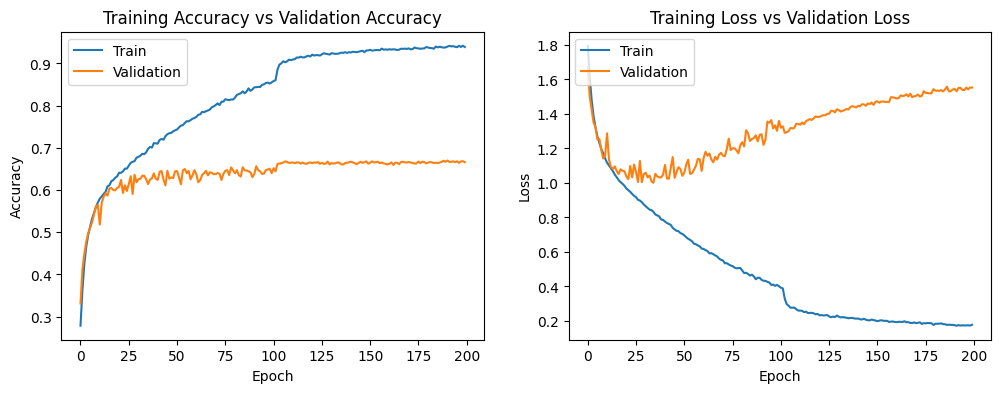

In [72]:
# Create plots for accuracy and loss.
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

ax[0].plot(train_accs)
ax[0].plot(val_accs)
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Pretrain Model


epoch
model_state_dict
optimizer_state_dict
train_loss
train_acc
val_loss
val_acc


<Figure size 640x480 with 0 Axes>

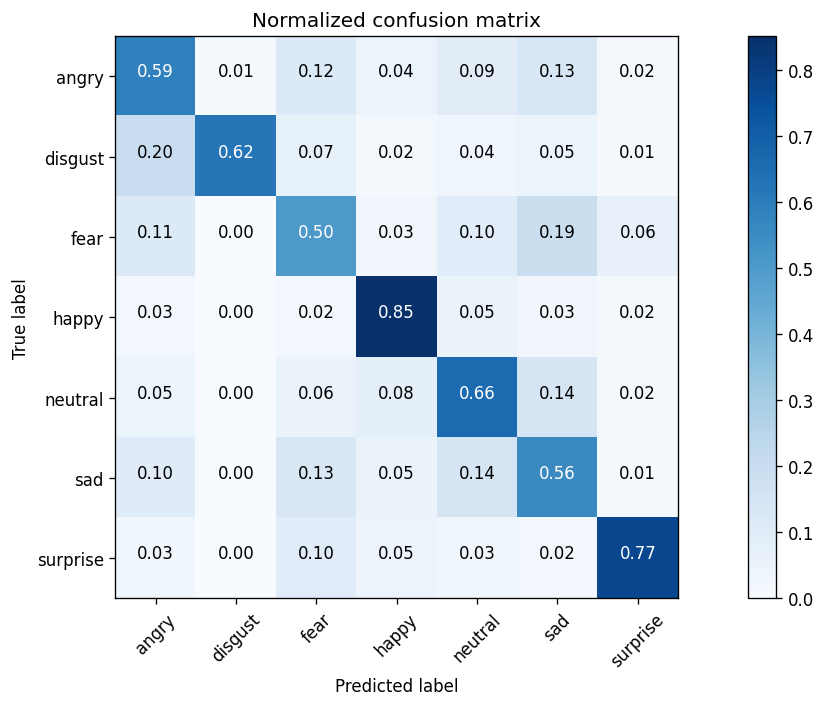

In [73]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# load the checkpoint file
checkpoint = torch.load('ResNet11-64.128.256/best_model.pth.tar')
for key in checkpoint:
    print(key)
        

# retrieve the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# compute predictions
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in val_set:
        inputs = inputs.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred += preds.tolist()
        y_true.append(labels)  # remove .tolist()

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create function to plot confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [19]:
epochs = 200
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
save_every = 50
# define your loss function
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True, cooldown=0, min_lr=0.001, eps=1e-08)
# define your checkpoint callback function
# load the checkpoint file
checkpoint = torch.load('ResNet11-64.128.256/best_model.pth.tar')

# retrieve the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

def save_checkpoint(state, is_best, filename='ResNet11-64.128.256/checkpoint.pth.tar', save_every=save_every):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'ResNet11-64.128.256/best_model_2.pth.tar')
    if state['epoch'] % save_every == 0:
        torch.save(state, f'ResNet11-64.128.256/checkpoint_2_epoch{state["epoch"]}.pth.tar')

# initialize variables for tracking training progress and best validation accuracy
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# train the model
for epoch in range(epochs):
    start=time.time()
    # train for one epoch
    model.to(device)
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # move inputs and labels to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

    # calculate average training loss and accuracy for the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # move inputs and labels to the same device as the model
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

    # calculate average validation loss and accuracy for the epoch
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # update the learning rate scheduler based on validation loss
    scheduler.step(-val_loss)

    # save checkpoint and best model
    is_best = val_acc > best_val_acc
    best_val_acc = max(val_acc, best_val_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }, is_best)

    # print training progress for the epoch
    stop=time.time()
    print(f'Time: {stop-start} Epoch {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f} Best Val Acc: {best_val_acc:.4f}')

print('Finished Training')

cuda
Time: 255.7680847644806 Epoch 1 Train Loss: 0.3304 Train Acc: 0.8818 Val Loss: 1.4849 Val Acc: 0.6471 Best Val Acc: 0.6471
Time: 66.62392616271973 Epoch 2 Train Loss: 0.3488 Train Acc: 0.8738 Val Loss: 1.4737 Val Acc: 0.6356 Best Val Acc: 0.6471
Time: 66.13283967971802 Epoch 3 Train Loss: 0.3507 Train Acc: 0.8747 Val Loss: 1.4291 Val Acc: 0.6495 Best Val Acc: 0.6495
Time: 65.26825070381165 Epoch 4 Train Loss: 0.3450 Train Acc: 0.8778 Val Loss: 1.4019 Val Acc: 0.6488 Best Val Acc: 0.6495
Time: 65.19664478302002 Epoch 5 Train Loss: 0.3504 Train Acc: 0.8744 Val Loss: 1.4788 Val Acc: 0.6492 Best Val Acc: 0.6495
Time: 64.73138332366943 Epoch 6 Train Loss: 0.3412 Train Acc: 0.8793 Val Loss: 1.4797 Val Acc: 0.6312 Best Val Acc: 0.6495
Time: 66.0718355178833 Epoch 7 Train Loss: 0.3386 Train Acc: 0.8791 Val Loss: 1.4090 Val Acc: 0.6500 Best Val Acc: 0.6500
Time: 65.06360363960266 Epoch 8 Train Loss: 0.3382 Train Acc: 0.8768 Val Loss: 1.4485 Val Acc: 0.6438 Best Val Acc: 0.6500
Time: 65.243

KeyboardInterrupt: 

Load model:

loaded_model = load_model("AlexNet_model-100iters.h5")
loaded_model.load_weights("AlexNet_model_weights-100iters.h5")